In [1]:
################################
## STEP 01: Import Libraries  ##
################################
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

#############################
## STEP 02: Read Data    ####
#############################
# Reading ratings file
df = pd.read_csv('products.csv')
display(df.sample(n=5, random_state=42))

,Product Name_TH,name_en,vendor_id,sku,order_id,state,completed_at,order_state,quantity,price,item_count,phone_number,gender,created_at,date_of_birth,geo_province,geo_district,date
289968,แคนตาลูปสวีต D25 (1.4 -1.7 กก./ลูก),Cantaloupe Sweet D25 (1.4-1.7 Kg./Pcs.),35,307,350066,complete,2023-10-06 04:21:14.756,completed,3,75.0,43,929407710,1,2023-01-16 16:19:23.134,1984-01-25,กรุงเทพมหานคร,เขตบางกะปิ,2023-10-06
442373,สุดคุ้ม!! 2 แพ็ค 329 องุ่นไชน์มัสแคท สายพันธุ์...,NaN,42,553,62538,complete,2022-10-13 07:17:44.895,completed,1,349.0,1,888613879,1,2022-10-13 07:12:37.029,1943-07-05,NaN,NaN,2022-10-13
160658,เซเลอรี่ (500ก./แพ็ค),Celery (500g./pack),347,8713,597369,complete,2024-01-17 16:34:16.784,completed,1,35.0,22,625632236,1,2024-01-03 09:15:33.052,1994-12-18,กรุงเทพมหานคร,เขตวัฒนา,2024-01-17
97220,เชอร์รี่ชิลี Size J ขนาด 26-28 มม. (0.9-1 กก./...,Chilean Cherry Size J 26-28 mm. (0.9-1 kg./Box),11,10011,754431,complete,2024-02-26 08:52:28.799,completed,2,398.0,5,886362999,1,2022-11-20 11:29:27.698,1980-03-21,นนทบุรี,อำเภอปากเกร็ด,2024-02-26
32450,เกรดบี ซื้อ 1 แถม 1 องุ่นดำไร้เมล็ดแม่มด AUS (...,Buy 1 get 1 free AUS Witch Seedless Black Grap...,367,11619,809701,complete,2024-05-15 14:23:35.327,on_delivery,1,350.0,14,818027889,0,2023-11-13 00:39:51.542,1972-09-06,กรุงเทพมหานคร,เขตราชเทวี,2024-05-15


In [2]:
data = df[['phone_number', 'sku']]
purchase_history = pd.DataFrame(data)
print(purchase_history)

        phone_number    sku
0          829973827  12487
1          829973827  13095
2          829973827   4953
3          829973827  13112
4          829973827  12619
...              ...    ...
451384     925271313     44
451385     865138242     21
451386     925271313     94
451387     985469466    119
451388     985469466    115

[451389 rows x 2 columns]


In [3]:
# Count the number of purchases for each user and product combination
purchase_counts = purchase_history.groupby(['phone_number', 'sku']).size().unstack(fill_value=0)

# Convert the purchase counts to a sparse matrix
sparse_purchase_counts = sparse.csr_matrix(purchase_counts)

# Compute the cosine similarity matrix between the products
cosine_similarities = cosine_similarity(sparse_purchase_counts.T)

# Define a function to recommend items for a user based on their purchase history
def recommend_items(phone_number, n=5):
    if phone_number not in purchase_counts.index:
        raise KeyError(f"Phone number {phone_number} not found in the data.")

    # Get the index of the user
    user_index = purchase_counts.index.get_loc(phone_number)

    # Get the user's purchase history
    user_history = sparse_purchase_counts[user_index].toarray().flatten()

    # Compute the average cosine similarity between the user's purchased items and all other items
    similarities = cosine_similarities.dot(user_history)

    # Get the indices of the user's purchased items
    purchased_indices = np.where(user_history > 0)[0]

    # Set the similarity scores for purchased items to 0
    similarities[purchased_indices] = 0

    # Sort the items by similarity score and return the top n items
    recommended_indices = np.argsort(similarities)[::-1][:n]
    recommended_items = list(purchase_counts.columns[recommended_indices])
    
    # Remove the items that the user has already purchased
    purchased_items = list(purchase_counts.columns[purchase_counts.loc[phone_number] > 0])
    recommended_items = [item for item in recommended_items if item not in purchased_items]

    return recommended_items

# Example usage:
example_phone_number = 944497151	
if example_phone_number in purchase_counts.index:
    print(f"Phone number {example_phone_number} found in the data.")
    recommendations = recommend_items(example_phone_number)
    print(f"Recommended items for phone number {example_phone_number}: {recommendations}")
else:
    print(f"Phone number {example_phone_number} not found in the data.")

Phone number 944497151 found in the data.
Recommended items for phone number 944497151: [330, 14, 5842, 55, 61]


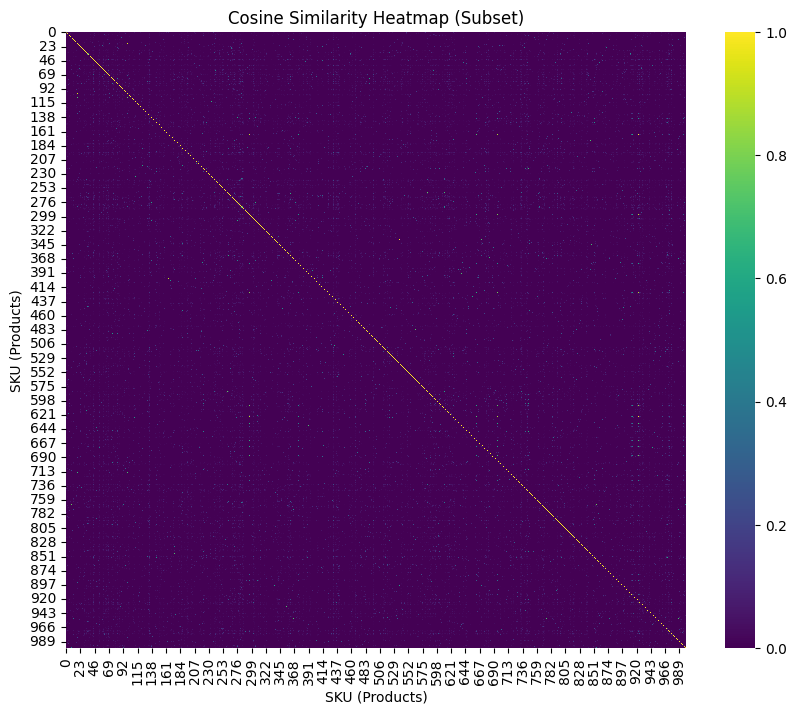

In [4]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Sample a subset of indices
sampled_indices = random.sample(range(cosine_similarities.shape[0]), 1000)
subset_cosine_similarities = cosine_similarities[sampled_indices][:, sampled_indices]

# Plot the heatmap for the subset
plt.figure(figsize=(10, 8))
sns.heatmap(subset_cosine_similarities, cmap='viridis')
plt.title('Cosine Similarity Heatmap (Subset)')
plt.xlabel('SKU (Products)')
plt.ylabel('SKU (Products)')
plt.show()


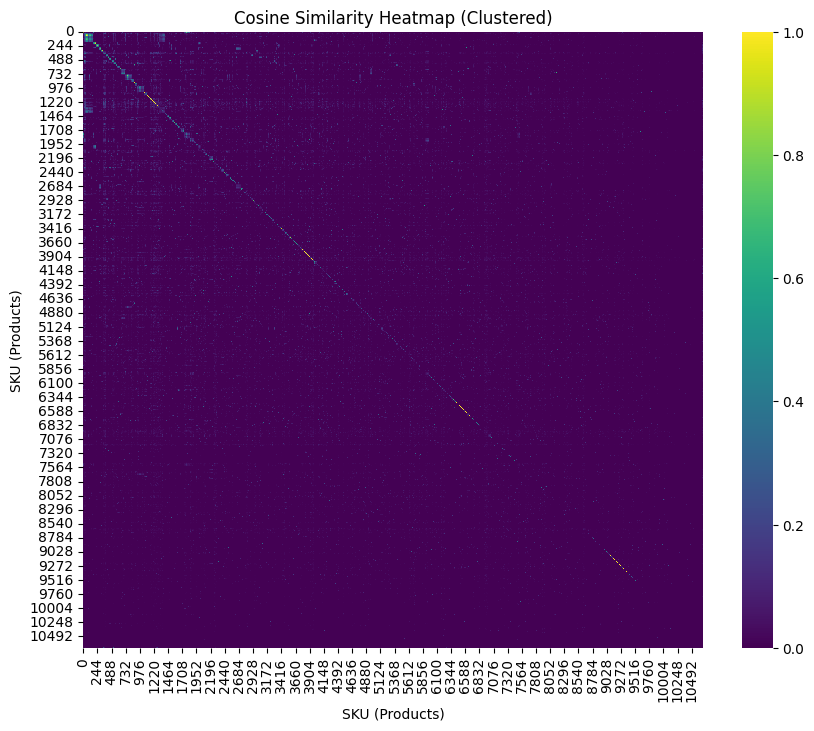

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as shc

# Assuming cosine_similarities is computed
# cosine_similarities = cosine_similarity(sparse_purchase_counts.T)

# Compute hierarchical clustering
linkage_matrix = shc.linkage(cosine_similarities, method='average')

# Optimal leaf ordering for hierarchical clustering
clustered_indices = shc.leaves_list(linkage_matrix)

# Plot the clustered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarities[clustered_indices][:, clustered_indices], cmap='viridis')
plt.title('Cosine Similarity Heatmap (Clustered)')
plt.xlabel('SKU (Products)')
plt.ylabel('SKU (Products)')
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# Assumption: purchase_history DataFrame already exists

# Step 1: Create a train-test split
def train_test_split(data, test_size=0.3):
    test_indices = np.random.choice(data.index, size=int(len(data) * test_size), replace=False)
    test_set = data.loc[test_indices]
    train_set = data.drop(test_indices)
    return train_set, test_set

train_data, test_data = train_test_split(purchase_history)

# Step 2: Create purchase counts and sparse matrix for train set
purchase_counts_train = train_data.groupby(['phone_number', 'sku']).size().unstack(fill_value=0)
sparse_purchase_counts_train = sparse.csr_matrix(purchase_counts_train)

# Compute cosine similarities for train set
cosine_similarities_train = cosine_similarity(sparse_purchase_counts_train.T)

# Define the recommend_items function
def recommend_items(phone_number, n=5):
    if phone_number not in purchase_counts_train.index:
        raise KeyError(f"Phone number {phone_number} not found in the data.")

    # Get the index of the user
    user_index = purchase_counts_train.index.get_loc(phone_number)

    # Get the user's purchase history
    user_history = sparse_purchase_counts_train[user_index].toarray().flatten()

    # Compute the average cosine similarity between the user's purchased items and all other items
    similarities = cosine_similarities_train.dot(user_history)

    # Get the indices of the user's purchased items
    purchased_indices = np.where(user_history > 0)[0]

    # Set the similarity scores for purchased items to 0
    similarities[purchased_indices] = 0

    # Sort the items by similarity score and return the top n items
    recommended_indices = np.argsort(similarities)[::-1][:n]
    recommended_items = list(purchase_counts_train.columns[recommended_indices])
    
    # Remove the items that the user has already purchased
    purchased_items = list(purchase_counts_train.columns[purchase_counts_train.loc[phone_number] > 0])
    recommended_items = [item for item in recommended_items if item not in purchased_items]

    return recommended_items

# Evaluate the model using test set
def evaluate_model(test_data, n=5):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for phone_number in test_data['phone_number'].unique():
        if phone_number in purchase_counts_train.index:
            purchased_items = set(test_data[test_data['phone_number'] == phone_number]['sku'])
            recommendations = recommend_items(phone_number, n=n)
            
            for item in recommendations:
                if item in purchased_items:
                    true_positive += 1
                else:
                    false_positive += 1
                    
            for item in purchased_items:
                if item not in recommendations:
                    false_negative += 1
                    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Example evaluation
precision, recall, f1 = evaluate_model(test_data)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Precision: 0.0257
Recall: 0.0232
F1 Score: 0.0244
